In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.offline as py
import plotly.express as px
from plotly.offline import iplot
import plotly.io as pio

from plotly.subplots import make_subplots
from plotly.graph_objs import Scatter, Layout, Figure, Data, Stream, YAxis, Marker, Bar, Line

import warnings
warnings.simplefilter(action='ignore', category=Warning)

!pip install klib
import sys

sys.path.append('../input/klib-library-python')
import klib
!pip install pdpipe
import pdpipe as pdp

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

     |████████████████████████████████| 50 kB 246 kB/s 
  Created wheel for decore: filename=decore-0.0.1-py2.py3-none-any.whl size=4192 sha256=15fa77c9c17851f2b6bd073e813d16f835d0bc3f9a85f87f1fe2c1017d3d8d97
  Stored in directory: /root/.cache/pip/wheels/71/8f/e1/b37357faaa92c7fbd2a8f735f96fcf032df04bcd3875465a3f
Successfully built decore
/kaggle/input/learnplatform-covid19-impact-on-digital-learning/products_info.csv
/kaggle/input/learnplatform-covid19-impact-on-digital-learning/README.md
/kaggle/input/learnplatform-covid19-impact-on-digital-learning/districts_info.csv
/kaggle/input/learnplatform-covid19-impact-on-digital-learning/engagement_data/6345.csv
/kaggle/input/learnplatform-covid19-impact-on-digital-learning/engagement_data/9812.csv
/kaggle/input/learnplatform-covid19-impact-on-digital-learning/engagement_data/2339.csv
/kaggle/input/learnplatform-covid19-impact-on-digital-learning/engagement_data/5404.csv
/kaggle/input/learnplatform-covid19-impact-on-digital-learning/engagem

### Reading Files

In [2]:
#Reading files
file_path_product = '/kaggle/input/learnplatform-covid19-impact-on-digital-learning/products_info.csv'
file_path_district = '/kaggle/input/learnplatform-covid19-impact-on-digital-learning/districts_info.csv'
df_product = pd.read_csv(file_path_product, encoding='utf8')
df_district = pd.read_csv(file_path_district, encoding='utf8')

### Creating function to append files
A helper fuction that pulls out all the engagement data related files by iterating through the engagement data folder. 

In [3]:
#Creting a list of all filenames
def append_filename():
    filename_list = []
    for filenames in os.walk('../input/learnplatform-covid19-impact-on-digital-learning/engagement_data/'):
        for filename in filenames:
            for csv in filename:
                if csv.find('.csv') >0:
                    filename_list.append(csv)
    return filename_list


Below function creates a combined files fo all the engagement data. 

In [4]:
#Creating a function to join all files together
def append_engagement_data():
    columns = ['time', 'lp_id', 'pct_access', 'engagement_index','district_id']
    df_master = pd.DataFrame(columns=columns)
    filename_list = append_filename()
    for filename in filename_list:
        file_path = f'../input/learnplatform-covid19-impact-on-digital-learning/engagement_data/{filename}'
        df_to_append = pd.read_csv(file_path, encoding='utf8')
        df_to_append["district_id"] = filename.split(".")[0]
        df_master = df_master.append(df_to_append)
    return df_master

In [5]:
#Calling the function to create a master dataframe
df_master = append_engagement_data()


### Code Cleanup

In [6]:
#Removing all NaN values
df_master.dropna(inplace = True)

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


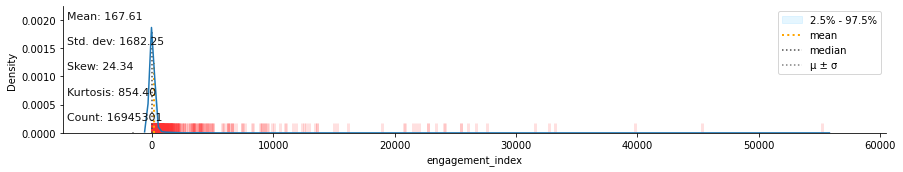

In [7]:
klib.dist_plot(df_master['engagement_index']);

In [8]:
df_dist = df_district.copy()
df_dist.isnull().sum()


district_id                   0
state                        57
locale                       57
pct_black/hispanic           57
pct_free/reduced             85
county_connections_ratio     71
pp_total_raw                115
dtype: int64

In [9]:
#removing NaN state rows
df_dist = df_dist.dropna(subset=['state'])

#replacing with the most frequent values
df_dist['pct_free/reduced'] = df_dist['pct_free/reduced'].fillna(df_dist['pct_free/reduced'].value_counts().idxmax())
df_dist['county_connections_ratio'] = df_dist['county_connections_ratio'].fillna(df_dist['county_connections_ratio'].value_counts().idxmax())
df_dist['pp_total_raw'] = df_dist['pp_total_raw'].fillna(df_dist['pp_total_raw'].value_counts().idxmax())
df_dist.isnull().sum()

district_id                 0
state                       0
locale                      0
pct_black/hispanic          0
pct_free/reduced            0
county_connections_ratio    0
pp_total_raw                0
dtype: int64

### average_columns_val 

Created to remove unncessary brackets and then, took avearage values of the resultant list. ['pct_black/hispanic','pct_free/reduced', 'county_connections_ratio', 'pp_total_raw'] 

In [10]:
def average_columns_val(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: str(x)[1:-1])
    df[["min","max" ]]= df[col_name].str.split(",", n = 1, expand = True)
    df = df.astype({'min': 'float', 'max':'float'})
    df[col_name] = (df['min']+df['max'])/2
    df = df.drop(columns = ['min','max'])
    return df

In [11]:
#Modifying columns for the analysis
df_dist_avg = average_columns_val(df_dist, "pct_black/hispanic")
df_dist_avg = average_columns_val(df_dist_avg, "pct_free/reduced")
df_dist_avg = average_columns_val(df_dist_avg, "county_connections_ratio")
df_dist_avg = average_columns_val(df_dist_avg, "pp_total_raw")

In [12]:
#Plotting states where the minority group has highest population
df_dist_avg = df_dist_avg.astype({'pct_black/hispanic':'float'})
df_dist_avg = df_dist_avg[df_dist_avg['pct_black/hispanic']>0.5]
df_state = df_dist_avg['state'].value_counts()

title_string = "No. of district ids where the black or hispanic pop is more than 50%"
fig = px.bar(x = df_state.index, y =df_state.values ,title="State Distribution",
              color_continuous_scale ='RdBu',color=df_state.values,height=500)

fig.update_layout(title_text=title_string)
fig.update_xaxes(title_text="<b> State </b>")
fig.update_yaxes(title_text="<b> Count of rows </b>")

fig.show()

In [13]:
#Number of products by company
df_pr_count = df_product['Provider/Company Name'].value_counts()
df_pr_count = df_pr_count[df_pr_count>3]
title_string = "Popular poducts"
fig = px.bar(x = df_pr_count.index, y =df_pr_count.values ,title="State Distribution",
              color_continuous_scale ='RdBu',color=df_pr_count.values,height=500)

fig.update_layout(title_text=title_string)
fig.update_xaxes(title_text="<b> Product Company </b>")
fig.update_yaxes(title_text="<b> Count of rows </b>")

fig.show()

In [14]:
#Couting products at various sectors
sector_dict = {'PreK-12':0,'Higher Ed':0, 'Corporate':0}
for sector in sector_dict.keys():
    val = df_product['Sector(s)'].str.contains(sector).sum()
    sector_dict.update({sector:val})
fig = px.pie(values= sector_dict.values(), names= sector_dict.keys(), title='Sector distribution')
fig.show()

In [15]:
#Couting primary essential services
primary_essential_dict = {'LC':0,'CM':0, 'SDO':0}
for essential in primary_essential_dict.keys():
    val = df_product['Primary Essential Function'].str.contains(essential).sum()
    primary_essential_dict.update({essential:val})

fig = px.pie(values= primary_essential_dict.values(), names= primary_essential_dict.keys(), title='Primary essential distribution')
fig.show()

The challenge is focussed on answering questions whether the digial learning engaged the students? Alos, does digital learning is beneficial to all group of communites? The notebook explore answering those questions?

Q1. What is the picture of digital connectivity and engagement in 2020?

In [16]:
df_product = df_product.rename(columns = {'LP ID':'lp_id'})
df_product.columns

Index(['lp_id', 'URL', 'Product Name', 'Provider/Company Name', 'Sector(s)',
       'Primary Essential Function'],
      dtype='object')

Understanding distribution of pct_acces and engagement data over the time period. 
It can be observed that the mean values are in fluctuating significanlty between the days. 

It is interesting to understand the behaviour. 

In [17]:
#Time and count of data
title_string = "Count of data for a day"
dft = df_master['time'].value_counts()
dft = dft.sort_index()
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Line(x = dft.index, y = dft.values, name = 'count of data for a day'))

fig.update_layout(title_text=title_string)
fig.update_xaxes(title_text="<b> Date </b>")
fig.update_yaxes(title_text="<b> Count of rows </b>", secondary_y=False)

fig.show()

In [18]:
#transforming dataframe to take rolling 7 days mean
df_master = df_master.astype({'district_id':'int32'})
df_merged_1 = pd.merge(df_master, df_dist_avg, on = "district_id")
df_merged=pd.merge(df_merged_1, df_product, on= "lp_id")

dfp =df_merged.groupby(["time"]).agg({'pct_access':['mean'], 'engagement_index':['mean']})
dfp.columns = dfp.columns.get_level_values(0)

dfp = dfp.reset_index()
dfc = dfp.rolling(window=7).mean()
dfc

,pct_access,engagement_index
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
...,...,...
361,0.395265,123.969838
362,0.313337,97.566632
363,0.235910,72.042834
364,0.180717,54.056281


In [19]:
title_string = "Pct_access and engagment_index 7-day mean over the days"
fig = make_subplots(specs=[[{"secondary_y": True}]])
    
#Adding graph elements
fig.add_trace(go.Line(x = dfc.index.get_level_values(0), y = dfc['pct_access'], name = 'pct_access'))
fig.add_trace(go.Line(x = dfc.index.get_level_values(0), y = dfc['engagement_index'], name = 'engagement_index'), secondary_y=True)

#Updating graph axes and title
fig.update_layout(title_text=title_string)
fig.update_xaxes(title_text="<b> Date </b>")
fig.update_yaxes(title_text="<b> pct_access </b>", secondary_y=False)
fig.update_yaxes(title_text="<b> engagement_index </b>", secondary_y=True)
        
fig.show()

Hypothesis 1: The cyclic behaviour of mean of pct_access depends on the count of data for days. 

In [20]:
#Finding correlation between 
df_hypo1 = dfp.merge(dft, how = 'left', left_index=True, right_index=True)
corr = df_hypo1.corr()
corr

,pct_access,engagement_index,time_y
pct_access,1.000000,0.888457,NaN
engagement_index,0.888457,1.000000,NaN
time_y,NaN,NaN,NaN


The correaltion shows that the mean of pct_access depend on the count of data for days. Hence, taking mean of pct_access gives a false represenation of data. Hence, it is better to remove products whose data are not available for each day. 

It is better to take rolling average over the single-day average as the count of data for each days is not uniform. 

Some observations on the engagement index:

1. The engagement index has been more in the later month of the year compare to earlier month. It shows the students have adopted digital learning over the period. 
2. The summer month has least engagment index as the students were enjoying their summer vacation. 

In [21]:
df_master.columns

dfk = df_merged.groupby(["time", "state"]).agg({'pct_access':['mean'], 'engagement_index':['mean']}).reset_index()
dfk.columns = dfk.columns.get_level_values(0)
dfk

,time,state,pct_access,engagement_index
0,2020-01-01,Arizona,0.416923,48.303077
1,2020-01-01,California,0.046960,3.118880
2,2020-01-01,Connecticut,0.169874,21.076415
3,2020-01-01,District Of Columbia,0.085957,13.356809
4,2020-01-01,Illinois,0.079606,6.758781
...,...,...,...,...
3110,2020-12-31,Illinois,0.167239,55.566586
3111,2020-12-31,Indiana,0.602105,100.938947
3112,2020-12-31,New York,0.887609,177.075870
3113,2020-12-31,Texas,0.051878,21.557716


The below function takes the engagement index data and assign a sign to it. 

In [22]:
def set_size(value):
    result = np.log(1+value/100)
    if result < 0:
        result = 0.001
    return result

In [23]:
#thanks to "https://www.kaggle.com/gvyshnya/covid19-impact-on-digital-learning-platforms-usage"

us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

pipeline = pdp.PdPipeline([
    pdp.ApplyByCols('engagement_index', set_size, 'size', drop=False),
    pdp.MapColVals('state', us_state_abbrev)
])
dfk = pipeline.apply(dfk)
dfk.fillna(0, inplace=True)

In [24]:
fig = px.scatter_geo(
    dfk, locations="state", locationmode='USA-states',
    scope="usa",
    color="engagement_index", 
    size='size', hover_name="state", 
    range_color= [0, 500], 
    projection="albers usa", animation_frame="time", 
    title='Average engagement index by province and date', 
    color_continuous_scale="portland")

fig.show()

The above plot shows that:

- The data is missing for many provinces. 
- The engagement index is bit higher in state of New York and Arizona.
- Even though California is world technical capital, the engagement index is comparatively less here. 

Q.2 - What is the effect of the COVID-19 pandemic on online and distance learning, and how might this also evolve in the future?

Ideas for analysis:

1. Shift in population learning online vs offline before and after March 2020. 
2. Does the trend continue? Need the data after covid effects were reduced in USA. 

Q.3. - How does student engagement with different types of education technology change over the course of the pandemic?